In [4]:
# Load the dataset. 
import mindspore.dataset as ds
import mindspore.dataset.vision as CV
from mindspore import dtype as mstype

train_data_path = 'C:/Users/DELL/Documents/HCIA/HCIA-AI V3.5/X-Experiment-Guide/2. Deep Learning and AI Development Framework Lab Guide/flower_photos/flower_photos_train/flower_photos_train'
val_data_path = 'C:/Users/DELL/Documents/HCIA/HCIA-AI V3.5/X-Experiment-Guide/2. Deep Learning and AI Development Framework Lab Guide/flower_photos/flower_photos_test/flower_photos_test'

def create_dataset(data_path, batch_size=18, training=True):
 
 """Define the dataset."""
 data_set = ds.ImageFolderDataset(data_path, num_parallel_workers=8, shuffle=True, class_indexing={'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4})
 
 # Perform image enhancement on the dataset.
 image_size = 224
 mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
 std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
 if training:
     trans = [
     CV.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
     CV.RandomHorizontalFlip(prob=0.5),
     CV.Normalize(mean=mean, std=std),
     CV.HWC2CHW()
     ]
 else:
     trans = [
     CV.Decode(),
     CV.Resize(256),
     CV.CenterCrop(image_size),
     CV.HWC2CHW()
     ]

 # Perform the data map, batch, and repeat operations.
 data_set = data_set.map(operations=trans, input_columns="image", num_parallel_workers=8)
 
 # Set the value of the batch_size. Discard the samples if the number of samples last fetched is less than the value of batch_size.
 data_set = data_set.batch(batch_size, drop_remainder=True)
 return data_set

dataset_train = create_dataset(train_data_path)
dataset_val = create_dataset(val_data_path)


Tensor of image (18, 3, 224, 224)
Labels: [1 3 0 0 1 4 0 2 1 2 3 3 1 3 4 4 2 3]


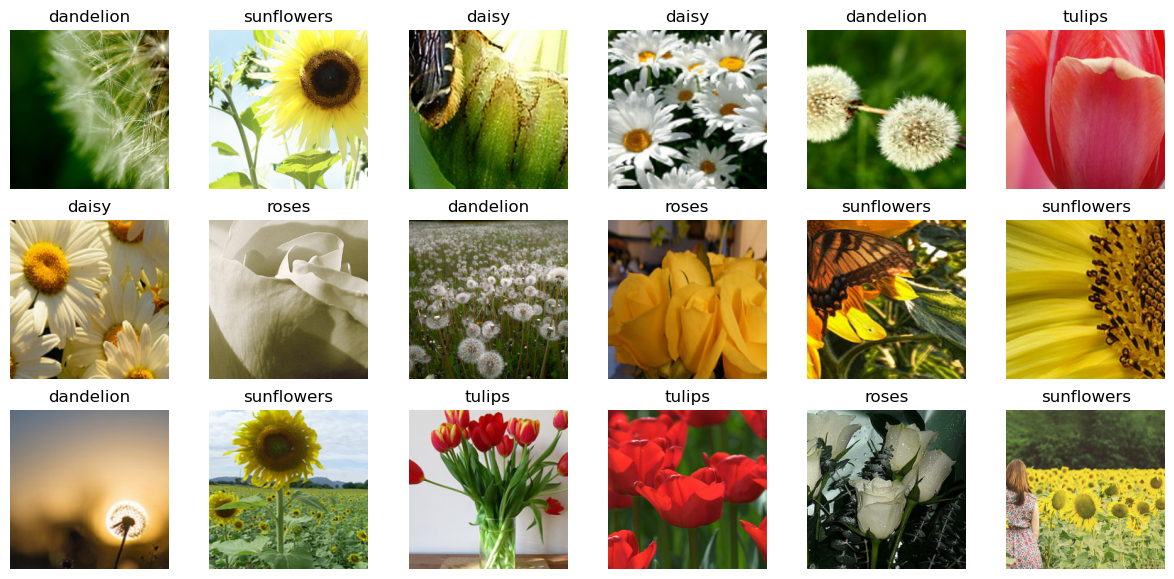

In [5]:
# Visualize the dataset.
import matplotlib.pyplot as plt
import numpy as np
data = next(dataset_train.create_dict_iterator())
images = data["image"]
labels = data["label"]
print("Tensor of image", images.shape)
print("Labels:", labels)

# class_name corresponds to label. Labels are marked in ascending order of the folder character string.
class_name = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
plt.figure(figsize=(15, 7))
for i in range(len(labels)):
 # Obtain an image and its label.
 data_image = images[i].asnumpy()
 data_label = labels[i]
 # Process images for display.
 data_image = np.transpose(data_image, (1, 2, 0))
 mean = np.array([0.485, 0.456, 0.406])
 std = np.array([0.229, 0.224, 0.225])
 data_image = std * data_image + mean
 data_image = np.clip(data_image, 0, 1)
 # Display the image.
 plt.subplot(3, 6, i + 1)
 plt.imshow(data_image)
 plt.title(class_name[int(labels[i].asnumpy())])
 plt.axis("off")
plt.show()

In [11]:
# Create a MobileNetV2 model.
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops

def _make_divisible(v, divisor, min_value=None):
 if min_value is None:
    min_value = divisor
 new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
 # Make sure that round down does not go down by more than 10%.
 if new_v < 0.9 * v:
    new_v += divisor
 return new_v


class GlobalAvgPooling(nn.Cell):
 def __init__(self):   
     super(GlobalAvgPooling, self).__init__()
     self.mean = ops.ReduceMean(keep_dims=False)
 def construct(self, x):
     x = self.mean(x, (2, 3))
     return x

class ConvBNReLU(nn.Cell):
 def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
     super(ConvBNReLU, self).__init__()
     padding = (kernel_size - 1) // 2
     in_channels = in_planes
     out_channels = out_planes
     if groups == 1:
         conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad', padding=padding)
     else:
         out_channels = in_planes
         conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad', padding=padding, group=in_channels)
     layers = [conv, nn.BatchNorm2d(out_planes), nn.ReLU6()]
     self.features = nn.SequentialCell(layers)
        
 def construct(self, x):
     output = self.features(x)
     return output


class InvertedResidual(nn.Cell):
 def __init__(self, inp, oup, stride, expand_ratio):
     super(InvertedResidual, self).__init__()
     assert stride in [1, 2]
     hidden_dim = int(round(inp * expand_ratio))
     self.use_res_connect = stride == 1 and inp == oup
     layers = []
     if expand_ratio != 1:
         layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
     layers.extend([
         # dw
         ConvBNReLU(hidden_dim, hidden_dim,stride=stride, groups=hidden_dim),
         # pw-linear
         nn.Conv2d(hidden_dim, oup, kernel_size=1,stride=1, has_bias=False),
         nn.BatchNorm2d(oup),
         ])
     self.conv = nn.SequentialCell(layers)
     self.add = ops.Add()
     self.cast = ops.Cast()
    
 def construct(self, x):
     identity = x
     x = self.conv(x)
     if self.use_res_connect:
         return self.add(identity, x)
     return x
    
    
class MobileNetV2Backbone(nn.Cell):
 def __init__(self, width_mult=1., inverted_residual_setting=None, round_nearest=8, input_channel=32, last_channel=1280):
     super(MobileNetV2Backbone, self).__init__()
     block = InvertedResidual
    
     # setting of inverted residual blocks
     self.cfgs = inverted_residual_setting
     if inverted_residual_setting is None:
         self.cfgs = [
         # t, c, n, s
         [1, 16, 1, 1],
         [6, 24, 2, 2],
         [6, 32, 3, 2],
         [6, 64, 4, 2],
         [6, 96, 3, 1],
         [6, 160, 3, 2],
         [6, 320, 1, 1],
         ]
     # building first layer
     input_channel = _make_divisible(input_channel * width_mult, round_nearest)
     self.out_channels = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
     features = [ConvBNReLU(3, input_channel, stride=2)]
     # building inverted residual blocks
     for t, c, n, s in self.cfgs:
         output_channel = _make_divisible(c * width_mult, round_nearest)
         for i in range(n):
             stride = s if i == 0 else 1
             features.append(block(input_channel, output_channel, stride, expand_ratio=t))
             input_channel = output_channel
     # building last several layers
     features.append(ConvBNReLU(input_channel, self.out_channels, kernel_size=1))
     # make it nn.CellList
     self.features = nn.SequentialCell(features)
     self._initialize_weights()
    
 def construct(self, x):
     x = self.features(x)
     return x

 def _initialize_weights(self):
     self.init_parameters_data()
     for _, m in self.cells_and_names():
         if isinstance(m, nn.Conv2d):
             n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
             m.weight.set_data(ms.Tensor(np.random.normal(0, np.sqrt(2. / n), m.weight.data.shape).astype("float32")))
             if m.bias is not None:
                 m.bias.set_data(ms.numpy.zeros(m.bias.data.shape, dtype="float32"))
         elif isinstance(m, nn.BatchNorm2d):
             m.gamma.set_data(ms.Tensor(np.ones(m.gamma.data.shape, dtype="float32")))
             m.beta.set_data(ms.numpy.zeros(m.beta.data.shape, dtype="float32"))
            
            
 @property
 def get_features(self):
     return self.features


class MobileNetV2Head(nn.Cell):
 def __init__(self, input_channel=1280, num_classes=1000, has_dropout=False, activation="None"):
     super(MobileNetV2Head, self).__init__()
     # mobilenet head
     head = ([GlobalAvgPooling()] if not has_dropout else [GlobalAvgPooling(), nn.Dropout(0.2)])
     self.head = nn.SequentialCell(head)
     self.dense = nn.Dense(input_channel, num_classes, has_bias=True)
     self.need_activation = True
     if activation == "Sigmoid":
         self.activation = ops.Sigmoid()
     elif activation == "Softmax":
         self.activation = ops.Softmax()
     else:
         self.need_activation = False
     self._initialize_weights()
    
    
 def construct(self, x):
     x = self.head(x)
     x = self.dense(x)
     if self.need_activation:
         x = self.activation(x)
     return x
 
 def _initialize_weights(self):
     self.init_parameters_data()
     for _, m in self.cells_and_names():
         if isinstance(m, nn.Dense):
             m.weight.set_data(ms.Tensor(np.random.normal(0, 0.01, m.weight.data.shape).astype("float32")))
             if m.bias is not None:
                 m.bias.set_data(ms.numpy.zeros(m.bias.data.shape, dtype="float32"))
                
                    
                    
class MobileNetV2Combine(nn.Cell):
 def __init__(self, backbone, head):
     super(MobileNetV2Combine, self).__init__(auto_prefix=False)
     self.backbone = backbone
     self.head = head
        
 def construct(self, x):
     x = self.backbone(x)
     x = self.head(x)
     return x
    
 
def mobilenet_v2(num_classes):
 backbone_net = MobileNetV2Backbone()
 head_net = MobileNetV2Head(backbone_net.out_channels,num_classes)
 return MobileNetV2Combine(backbone_net, head_net)

In [12]:
# Train and validate the model.
import mindspore
import mindspore.nn as nn
from mindspore.train import Model
from mindspore import Tensor, save_checkpoint
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net

# Create a model. The number of target classes is 5.
network = mobilenet_v2(5)

# Load the pre-trained weight.
param_dict = load_checkpoint("./mobilenetv2_ascend_v170_imagenet2012_official_cv_top1acc71.88.ckpt")

# Modify the weight data based on the modified model structure.
param_dict["dense.weight"] = mindspore.Parameter(Tensor(param_dict["dense.weight"][:5, :],mindspore.float32), name="dense.weight", requires_grad=True)
param_dict["dense.bias"] = mindspore.Parameter(Tensor(param_dict["dense.bias"][:5, ],mindspore.float32), name="dense.bias", requires_grad=True)

# Load the modified weight parameters to the model.
load_param_into_net(network, param_dict)
train_step_size = dataset_train.get_dataset_size()
epoch_size = 20
lr = nn.cosine_decay_lr(min_lr=0.0, max_lr=0.1,total_step=epoch_size * train_step_size, step_per_epoch=train_step_size, decay_epoch=200)

# Define the optimizer.
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)

# Define the loss function.
network_loss = loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# Define evaluation metrics.
metrics = {"Accuracy": nn.Accuracy()}

# Initialize the model.
model = Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

# Monitor the loss value.
loss_cb = LossMonitor(per_print_times=train_step_size)

# Set the number of steps for saving a model and the maximum number of models that can be saved.
ckpt_config = CheckpointConfig(save_checkpoint_steps=100, keep_checkpoint_max=10)

# Save the model. Set the name, path, and parameters for saving the model.
ckpoint_cb = ModelCheckpoint(prefix="mobilenet_v2", directory='./ckpt1', config=ckpt_config)
print("============== Starting Training ==============")

# Train a model, set the number of training times to 5, and set the training set and callback function.
model.train(5, dataset_train, callbacks=[loss_cb,ckpoint_cb], dataset_sink_mode=True)

# Use the test set to validate the model and output the accuracy of the test set.
metric = model.eval(dataset_val)
print(metric)

============== Starting Training ==============
epoch: 1 step: 201, loss is 0.46450525522232056
epoch: 2 step: 201, loss is 0.24258235096931458
epoch: 3 step: 201, loss is 0.4879034459590912
epoch: 4 step: 201, loss is 0.07446896284818649
epoch: 5 step: 201, loss is 0.3593370020389557
{'Accuracy': 0.8888888888888888}


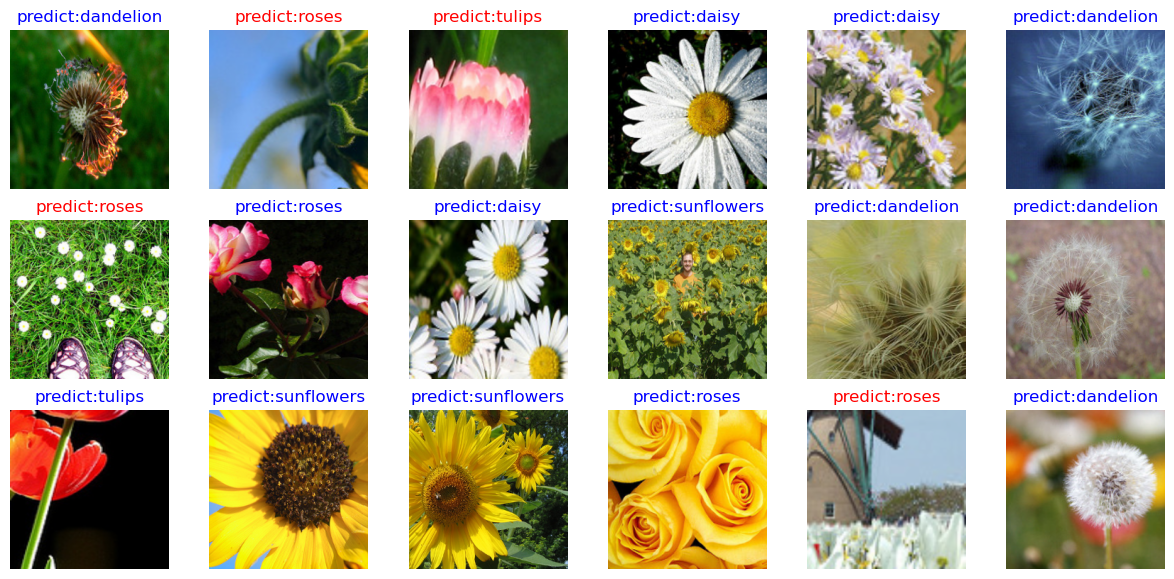

In [13]:
# Visualize the model prediction result. 

import matplotlib.pyplot as plt
import mindspore as ms
def visualize_model(best_ckpt_path, val_ds):
 num_class = 5 # Perform binary classification on wolf and dog images.
 net = mobilenet_v2(num_class)
 # Load model parameters.
 param_dict = ms.load_checkpoint(best_ckpt_path)
 ms.load_param_into_net(net, param_dict)
 model = ms.Model(net)
 # Load the validation dataset.
 data = next(val_ds.create_dict_iterator())
 images = data["image"].asnumpy()
 labels = data["label"].asnumpy()
 class_name = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
 # Predict the image type.
 output = model.predict(ms.Tensor(data['image']))
 pred = np.argmax(output.asnumpy(), axis=1)
 # Display the image and the predicted value of the image.
 plt.figure(figsize=(15, 7))
 for i in range(len(labels)):
     plt.subplot(3, 6, i + 1)
     # If the prediction is correct, it is displayed in blue. If the prediction is incorrect, it is displaye d in red.
     color = 'blue' if pred[i] == labels[i] else 'red'
     plt.title('predict:{}'.format(class_name[pred[i]]), color=color)
     picture_show = np.transpose(images[i], (1, 2, 0))
     mean = np.array([0.485, 0.456, 0.406])
     std = np.array([0.229, 0.224, 0.225])
     picture_show = std * picture_show + mean
     picture_show = np.clip(picture_show, 0, 1)
     plt.imshow(picture_show)
     plt.axis('off')
 plt.show()


visualize_model('ckpt1/mobilenet_v2-5_201.ckpt', dataset_val)